In [1]:
import healpy as hp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
from sympy.physics.wigner import wigner_3j
from sympy import N

In [66]:
def _w3(l1,l2,l3):
    return N(wigner_3j(l1,l2,l3,0,0,0))
_w3 = np.vectorize(_w3)

In [170]:
def master(l1,l2,wl,lmax=None):
    """Calculate component (l1,l2) of M matrix.
    > Parameters:
    l1,l2: ints, elements of matrix
    wl: numpy array, power spectrum of mask
    lmax: int, if not give lmax is taken from wl
    > Returns:
    M_l1l2: float, element (l1,l2) of M matrix"""
    if lmax is None:
        wl_in = np.copy(wl)
        lmax_in = len(wl)-1
    elif len(wl) >= (lmax+1):
        wl_in = wl[:lmax+1]
        lmax_in = lmax
    elif len(wl) < (lmax+1):
        lmax_in = len(wl) - 1
        wl_in = np.copy(wl)
        print("lmax > len(wl)-1, using lmax = len(wl) -1 = {} instead".format(lmax_in))
    l3 = np.arange(lmax_in+1)
    sum_l3 = np.sum((2*l3+1)*wl_in*_w3(l1,l2,l3)**2)
    return (2*l2+1)*sum_l3/(4*np.pi)

In [231]:
def master_matrix(wl,lmax=None):
    """Calculate M matrix as (lmax+1,lmax+1) ndarray.
    > Parameters:
    wl: numpy array, power spectrum of mask
    lmax: int, if not give lmax is taken from wl
    > Returns:
    M: ndarray of dimension, the master matrix"""
    if lmax is None:
        lmax_in = len(wl)-1
    else:
        lmax_in = lmax
    def master2(l1,l2):
        return master(l1,l2,wl,lmax_in)
    master2 = np.vectorize(master2)
    lrange = np.arange(lmax_in+1)
    l1v,l2v = np.meshgrid(lrange,lrange)
    matrix = master2(l1v,l2v)
    return np.asfarray(matrix)

In [223]:
mask = hp.read_map('wiener_filter/commander_mask_n16.fits', verbose=False)
nside = hp.get_nside(mask)
lmax = 2*nside
wl = hp.anafast(mask,lmax=lmax)
cl = np.load('wiener_filter/cls_PlanckPR2_TT_lowp_lensing_lensed.npy')

In [230]:
m = master_matrix(wl)

In [237]:
m_bf = np.zeros((lmax+1,lmax+1))
for l1 in range(lmax+1):
    for l2 in range(lmax+1):
        m_bf[l1,l2] = master(l1,l2,wl)

In [151]:
# testing method

In [162]:
cl_mu = np.zeros(lmax+1)
cl_til_mu = np.zeros(lmax+1)
n = 1000
for i in range(n):
    map_ = hp.synfast(cl,nside, lmax, verbose=False)
    cl_mu += hp.anafast(map_,lmax=lmax)
    map_[mask == 0] = hp.UNSEEN
    cl_til_mu += hp.anafast(map_,lmax=lmax)
df = pd.DataFrame(dict(cl = cl_mu/n, cl_til = cl_til_mu/n))

In [238]:
df['cl_m'] = np.dot(m_bf,df.cl)

In [239]:
df.describe()

,cl,cl_til,cl_m
count,3.300000e+01,33.000000,33.000000
mean,8.617079e+01,37.956297,37.819307
std,2.118194e+02,76.242889,76.699397
min,2.430423e-09,4.153844,3.350161
25%,8.794218e+00,5.892855,5.609037
50%,1.599686e+01,10.297732,10.128872
75%,4.753208e+01,27.465380,27.412778
max,1.122140e+03,403.656087,405.370530


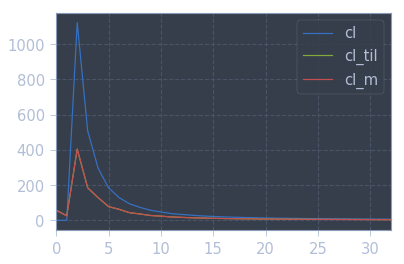

In [240]:
df.plot()
plt.show()